## Objective
Provide a quick supply-versus-demand balance by zone using the configured EPM input bundle. The notebook loads demand and generation files from `config.csv`, filters active plants, estimates their capacity factors, and visualizes capacity and energy against demand.

### Step 1 – Configure the working folder
Import core libraries and point to the `folder_input` you want to analyze.

In [1]:
from pathlib import Path
import csv
import sys
import pandas as pd


folder_input = 'data_test'

### Step 2 – Resolve data paths and load raw inputs
Find the project root, add the plotting helpers to the Python path, and load demand and generation tables referenced in `config.csv`.

In [2]:
# Locate the repository root that contains the working `epm` directory.
def locate_project_root(marker: str = "epm") -> Path:
    """Return the nearest ancestor containing the marker directory."""
    for directory in [Path.cwd(), *Path.cwd().parents]:
        candidate = directory / marker
        if candidate.is_dir():
            return directory
    raise FileNotFoundError("Could not find 'epm' directory above the current working directory.")


# Read CSV files safely using the standard library to dodge pandas engine crashes.
def load_csv(path: Path) -> pd.DataFrame:
    """Read a CSV using DictReader to avoid pandas engine crashes."""
    with path.open(newline='', encoding='utf-8-sig') as handle:
        reader = csv.DictReader(handle)
        records = list(reader)
    if not records:
        return pd.DataFrame(columns=reader.fieldnames or [])
    return pd.DataFrame(records)


project_root = locate_project_root()
input_root = project_root / "epm" / "input" / folder_input

# Add `epm/postprocessing` to the Python path so plotting helpers can be imported.
postprocessing_root = project_root / "epm"
if str(postprocessing_root) not in sys.path:
    sys.path.append(str(postprocessing_root))

config_path = input_root / "config.csv"
if not config_path.exists():
    raise FileNotFoundError(f"Missing config file at {config_path}")

config_lookup = (
    pd.read_csv(config_path)
      .loc[:, ["paramNames", "file"]]
      .dropna(subset=["paramNames", "file"])
      .set_index("paramNames")["file"]
)


# Resolve a parameter name to the actual CSV path referenced in config.csv.
def resolve_param_path(param_name: str) -> Path:
    """Resolve a parameter name to a CSV path via config.csv."""
    relative = config_lookup.get(param_name)
    if relative is None:
        raise KeyError(f"{param_name} not found in {config_path}")
    resolved = input_root / relative
    if not resolved.exists():
        raise FileNotFoundError(
            f"{param_name} points to {resolved} but the file does not exist."
        )
    return resolved


# Load inputs
demand_peak_path = resolve_param_path("pDemandForecast")
generation_path = resolve_param_path("pGenDataInput")

demand_peak_df = pd.read_csv(demand_peak_path)

# Generation CSV occasionally crashes pandas; use custom loader.
generation_df = load_csv(generation_path)


### Step 3 – Prepare demand and generation summaries
Clean the datasets, apply capacity-factor fallbacks, and build zone-level capacity and energy mixes through the modelling years up to `TARGET_YEAR`.

In [3]:
import numpy as np

HOURS_PER_YEAR = 8_760
MW_TO_GWH = HOURS_PER_YEAR / 1_000
TARGET_YEAR = 2040


# Load optional parameters referenced in config.csv; return an empty DataFrame if absent.
def load_param_csv(param_name: str) -> pd.DataFrame:
    """Return the DataFrame for a config parameter or an empty DataFrame when missing."""
    try:
        return load_csv(resolve_param_path(param_name))
    except (KeyError, FileNotFoundError):
        return pd.DataFrame()


# Demand prep
value_columns = [c for c in demand_peak_df.columns if c not in {"zone", "type"}]
model_years = sorted(year for year in map(int, value_columns) if year <= TARGET_YEAR)
if not model_years:
    raise ValueError(f"No demand columns found for years up to {TARGET_YEAR}.")

demand_columns = [str(year) for year in model_years]

for column in demand_columns:
    demand_peak_df[column] = pd.to_numeric(demand_peak_df[column], errors='coerce')

demand_peak_df["zone"] = demand_peak_df["zone"].astype(str).str.strip()
demand_peak_df["type"] = demand_peak_df["type"].astype(str).str.strip()

zcmap_df = load_param_csv("zcmap")
if not zcmap_df.empty and "zone" in zcmap_df.columns:
    valid_zones = zcmap_df["zone"].astype(str).str.strip().unique().tolist()
else:
    valid_zones = demand_peak_df["zone"].unique().tolist()
valid_zones_set = set(valid_zones)

demand_peak_df = demand_peak_df[demand_peak_df["zone"].isin(valid_zones_set)].copy()


# Convert demand tables into long format by year.
def reshape_demand(demand_type: str) -> pd.DataFrame:
    """Return long-form demand series for the requested demand type."""
    subset = demand_peak_df.loc[demand_peak_df["type"] == demand_type, ["zone", *demand_columns]].copy()
    if subset.empty:
        return pd.DataFrame(columns=["zone", "year", "value"])
    melted = subset.melt(id_vars="zone", value_vars=demand_columns, var_name="year", value_name="value")
    melted["year"] = melted["year"].astype(int)
    melted["value"] = pd.to_numeric(melted["value"], errors='coerce')
    return melted.dropna(subset=["value"])


peak_demand = reshape_demand("Peak")
energy_demand = reshape_demand("Energy")


# Generation prep
generation_df["Status"] = pd.to_numeric(generation_df["Status"], errors='coerce')
generation_df["Capacity"] = pd.to_numeric(generation_df["Capacity"], errors='coerce')
for column in ["gen", "zone", "tech", "fuel"]:
    if column in generation_df.columns:
        generation_df[column] = generation_df[column].astype(str).str.strip()

if "zone" in generation_df.columns:
    generation_df = generation_df[generation_df["zone"].isin(valid_zones_set)].copy()

active_status = [1, 2]
generation_active = generation_df[generation_df["Status"].isin(active_status)].copy()
generation_active["Status"] = generation_active["Status"].astype(int)
generation_active["Capacity"] = generation_active["Capacity"].fillna(0)

min_year = min(model_years)
max_year = max(model_years)
generation_active["start_year"] = pd.to_numeric(generation_active.get("StYr"), errors='coerce').fillna(min_year)
generation_active["retire_year"] = pd.to_numeric(generation_active.get("RetrYr"), errors='coerce').fillna(max_year)


# Tidy generator availability tables and compute an average capacity factor per grouping.
def tidy_availability(frame: pd.DataFrame, group_cols: list[str]) -> pd.DataFrame:
    """Return averaged capacity factors for the provided grouping columns."""
    if frame is None or frame.empty:
        return pd.DataFrame(columns=group_cols + ["capacity_factor"])
    data = frame.copy()
    for column in group_cols:
        if column in data.columns:
            data[column] = data[column].astype(str).str.strip()
    value_cols = [c for c in data.columns if c not in group_cols]
    for column in value_cols:
        data[column] = pd.to_numeric(data[column], errors='coerce')
    if not value_cols:
        data["capacity_factor"] = np.nan
    else:
        data["capacity_factor"] = data[value_cols].mean(axis=1, skipna=True)
    return data[group_cols + ["capacity_factor"]].dropna(subset=["capacity_factor"])


availability_custom = tidy_availability(load_param_csv("pAvailability"), ["gen"])
availability_default = tidy_availability(load_param_csv("pAvailabilityDefault"), ["zone", "tech", "fuel"])

custom_cf = availability_custom.set_index("gen")["capacity_factor"].to_dict()
default_cf = availability_default.set_index(["zone", "tech", "fuel"])["capacity_factor"].to_dict()
default_cf_tf = availability_default.groupby(["tech", "fuel"], observed=False)["capacity_factor"].mean().to_dict()
default_cf_f = availability_default.groupby(["fuel"], observed=False)["capacity_factor"].mean().to_dict()
global_cf = availability_default["capacity_factor"].mean() if not availability_default.empty else np.nan


# Choose the best-matching capacity factor for each generator, falling back gracefully.
def capacity_factor_lookup(row: pd.Series) -> float:
    """Return the most granular capacity factor available for the generator."""
    generator = row.get("gen", "")
    if generator in custom_cf:
        return custom_cf[generator]

    zone, tech, fuel = row.get("zone"), row.get("tech"), row.get("fuel")
    key_zone = (zone, tech, fuel)
    if key_zone in default_cf:
        return default_cf[key_zone]

    key_tf = (tech, fuel)
    if key_tf in default_cf_tf:
        return default_cf_tf[key_tf]

    if fuel in default_cf_f:
        return default_cf_f[fuel]

    return float(global_cf) if pd.notna(global_cf) else 0.5


# Evaluate generator capacity factors.
generation_active["capacity_factor"] = generation_active.apply(capacity_factor_lookup, axis=1)
generation_active["capacity_factor"] = generation_active["capacity_factor"].fillna(0)

generation_active["zone"] = generation_active.get("zone", "").astype(str).str.strip()

postprocessing_static = project_root / "epm" / "postprocessing" / "static"
colors_path = postprocessing_static / "colors.csv"
fuels_path = postprocessing_static / "fuels.csv"

fuel_mapping = pd.read_csv(fuels_path).set_index("EPM_Fuel")["Processing"].to_dict()
color_lookup = pd.read_csv(colors_path).set_index("Processing")["Color"].to_dict()

generation_active["fuel_processed"] = generation_active["fuel"].map(fuel_mapping).fillna(generation_active["fuel"])
missing_categories = set(generation_active["fuel_processed"].unique()).difference(color_lookup)
for category in missing_categories:
    color_lookup[category] = "#999999"


# Determine which planning years each generator is online.
def compute_active_years(row: pd.Series) -> list[int]:
    """Return the planning years during which the plant is online."""
    return [year for year in model_years if year >= row["start_year"] and year <= row["retire_year"]]


generation_active["active_years"] = generation_active.apply(compute_active_years, axis=1)
generation_active = generation_active[generation_active["active_years"].map(len) > 0]

if generation_active.empty:
    capacity_mix = pd.DataFrame(columns=["zone", "fuel", "year", "value"])
    energy_mix = pd.DataFrame(columns=["zone", "fuel", "year", "value"])
else:
    generation_yearly = generation_active.explode("active_years").rename(columns={"active_years": "year"})
    generation_yearly["year"] = generation_yearly["year"].astype(int)

    capacity_mix = (
        generation_yearly.groupby(["zone", "fuel_processed", "year"], observed=False)["Capacity"]
        .sum()
        .reset_index()
        .rename(columns={"fuel_processed": "fuel", "Capacity": "value"})
    )

    energy_mix = (
        generation_yearly.assign(energy_gwh=lambda df: df["Capacity"] * df["capacity_factor"] * MW_TO_GWH)
        .groupby(["zone", "fuel_processed", "year"], observed=False)["energy_gwh"]
        .sum()
        .reset_index()
        .rename(columns={"fuel_processed": "fuel", "energy_gwh": "value"})
    )

capacity_mix = capacity_mix[capacity_mix["zone"].isin(valid_zones_set)]
energy_mix = energy_mix[energy_mix["zone"].isin(valid_zones_set)]
peak_demand = peak_demand[peak_demand["zone"].isin(valid_zones_set)]
energy_demand = energy_demand[energy_demand["zone"].isin(valid_zones_set)]


### Step 4 – Plot capacity and energy balances
Use the EPM post-processing helper to compare supply stacks with peak and annual demand across zones.

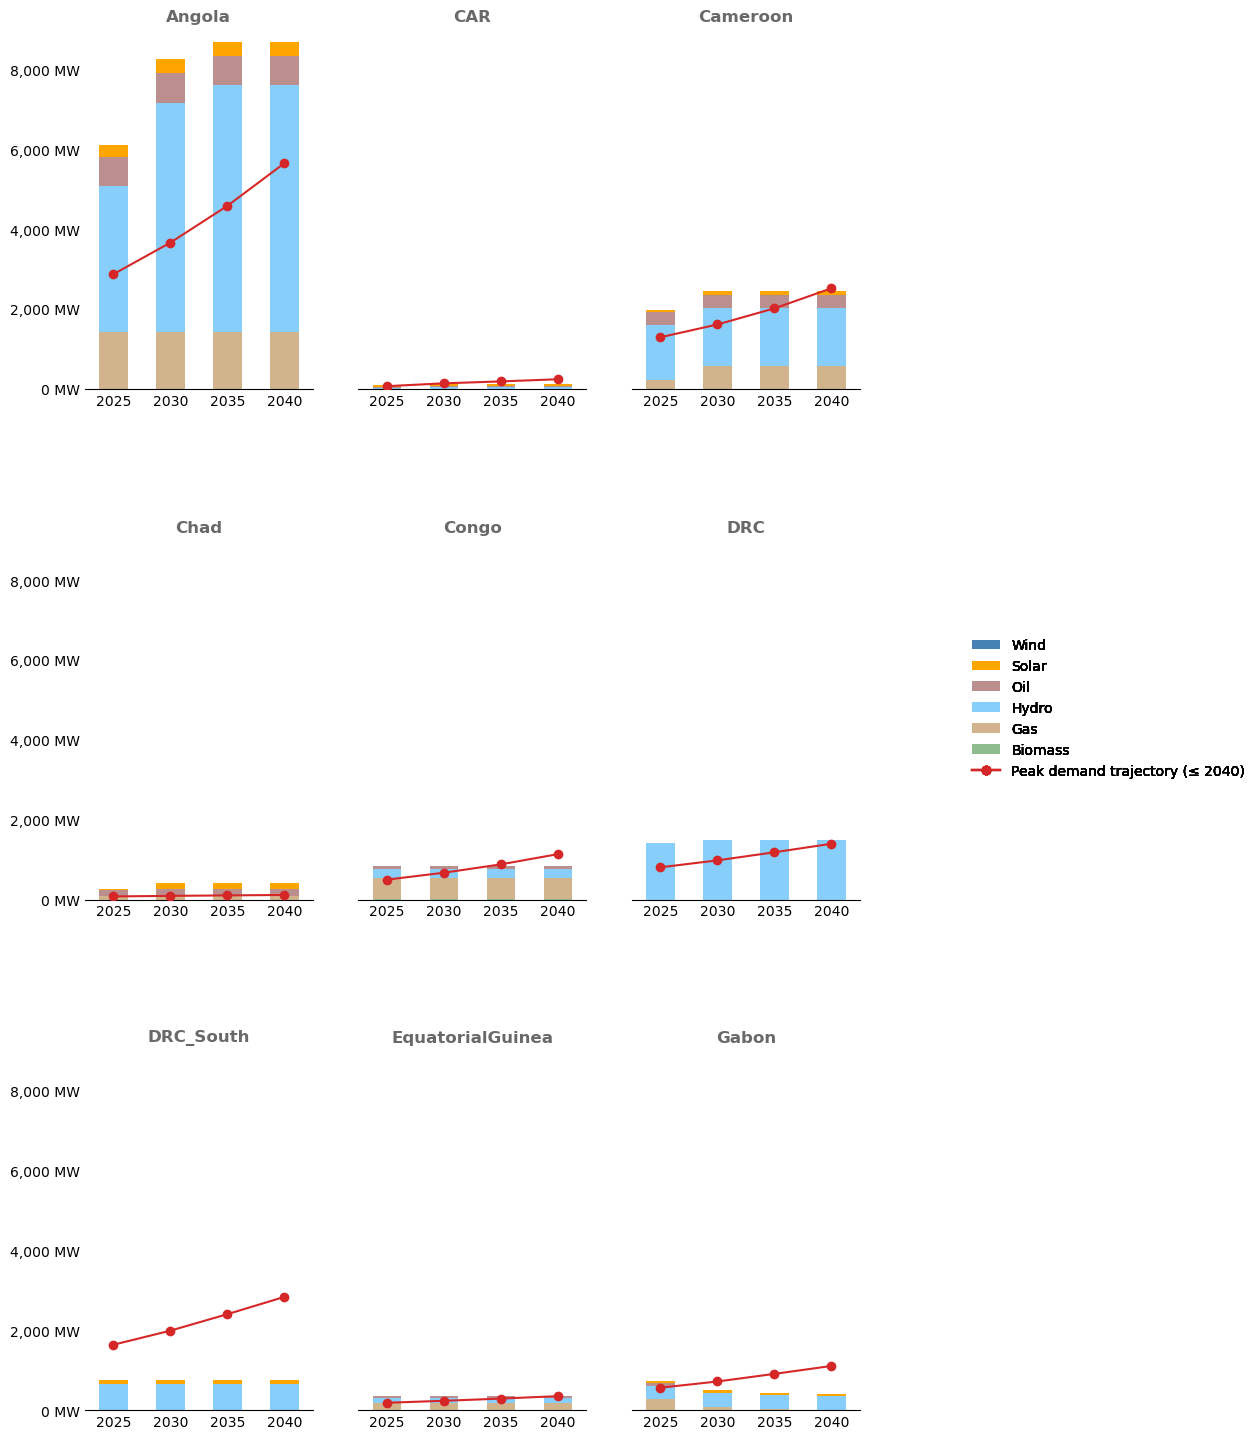

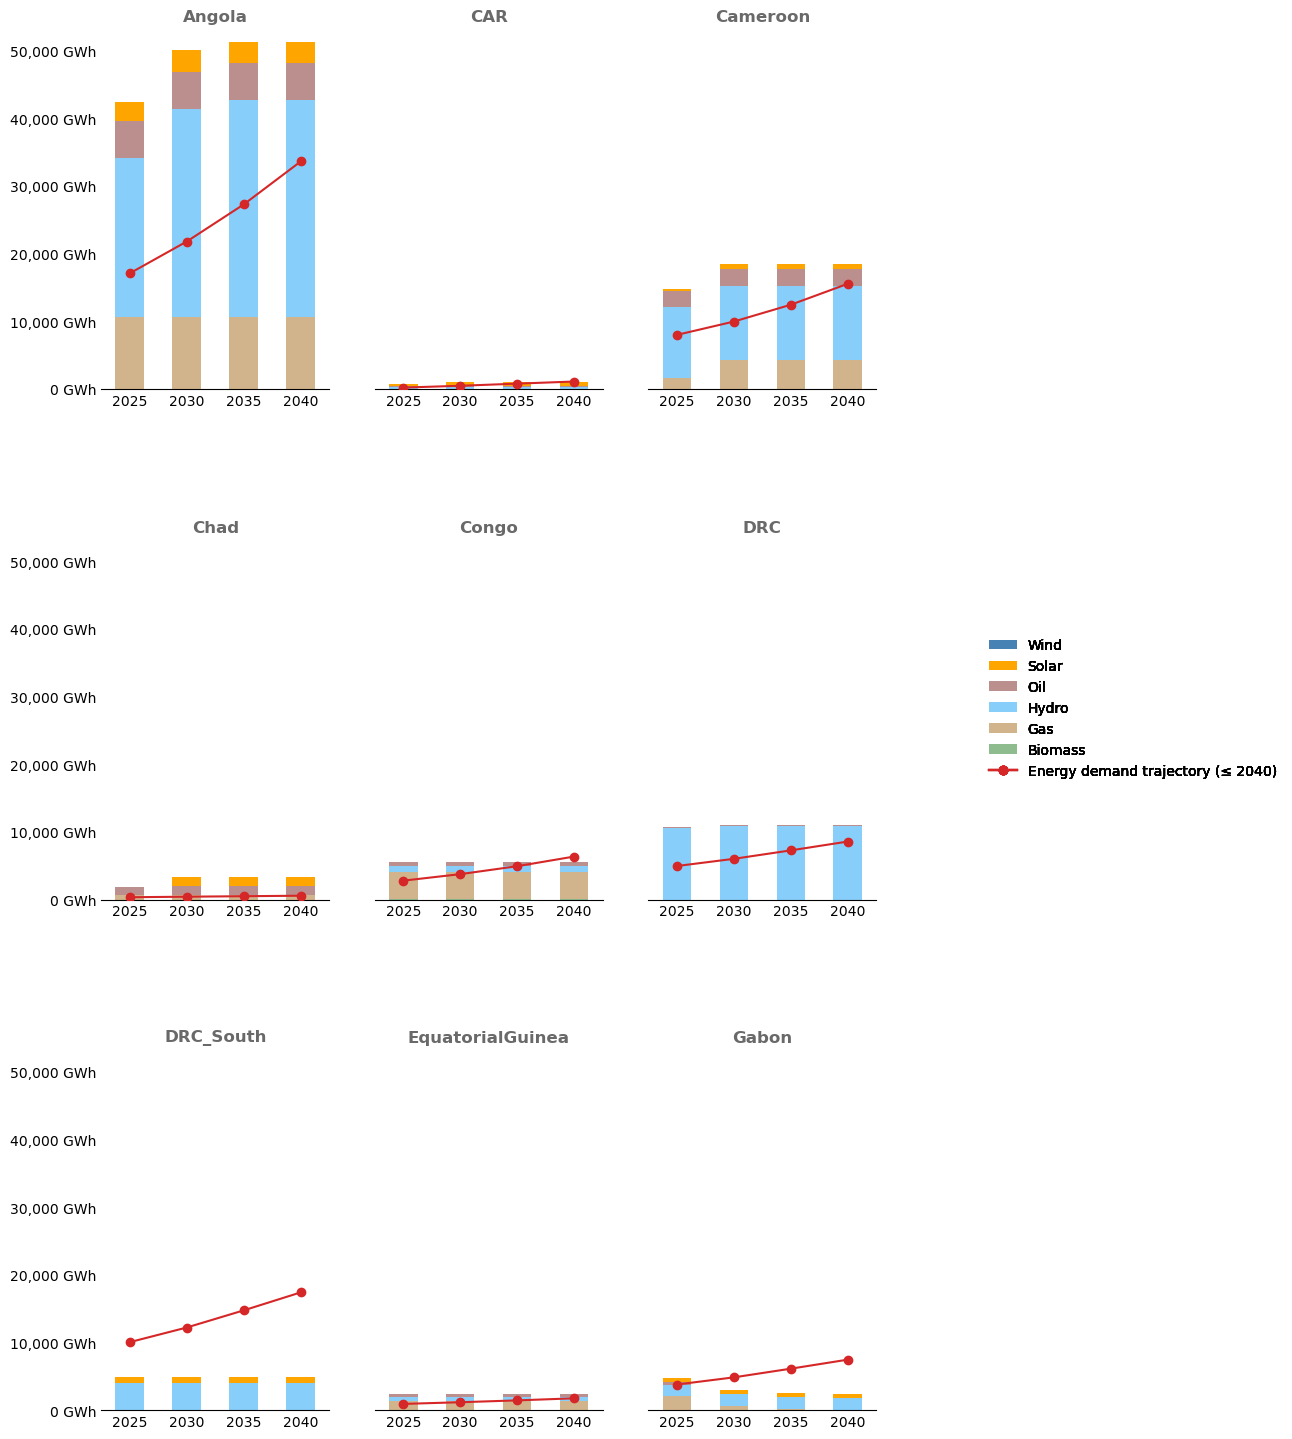

In [4]:
from postprocessing.plots import make_stacked_barplot

if capacity_mix.empty:
    raise ValueError("No capacity data available after filtering statuses 1 and 2.")
if energy_mix.empty:
    raise ValueError("No energy data available after filtering statuses 1 and 2.")

order_years = model_years

make_stacked_barplot(
    capacity_mix,
    filename=None,
    dict_colors=color_lookup,
    overlay_df=peak_demand,
    legend_label=f"Peak demand trajectory (≤ {TARGET_YEAR})",
    column_subplot='zone',
    column_stacked='fuel',
    column_xaxis='year',
    column_value='value',
    annotate=False,
    order_scenarios=order_years,
    format_y=lambda value, _: f"{value:,.0f} MW"
)

make_stacked_barplot(
    energy_mix,
    filename=None,
    dict_colors=color_lookup,
    overlay_df=energy_demand,
    legend_label=f"Energy demand trajectory (≤ {TARGET_YEAR})",
    column_subplot='zone',
    column_stacked='fuel',
    column_xaxis='year',
    column_value='value',
    annotate=False,
    order_scenarios=order_years,
    format_y=lambda value, _: f"{value:,.0f} GWh"
)


### Step 5 – System overview
Aggregate the zone results into a single system-level stack to compare nationwide supply with demand.

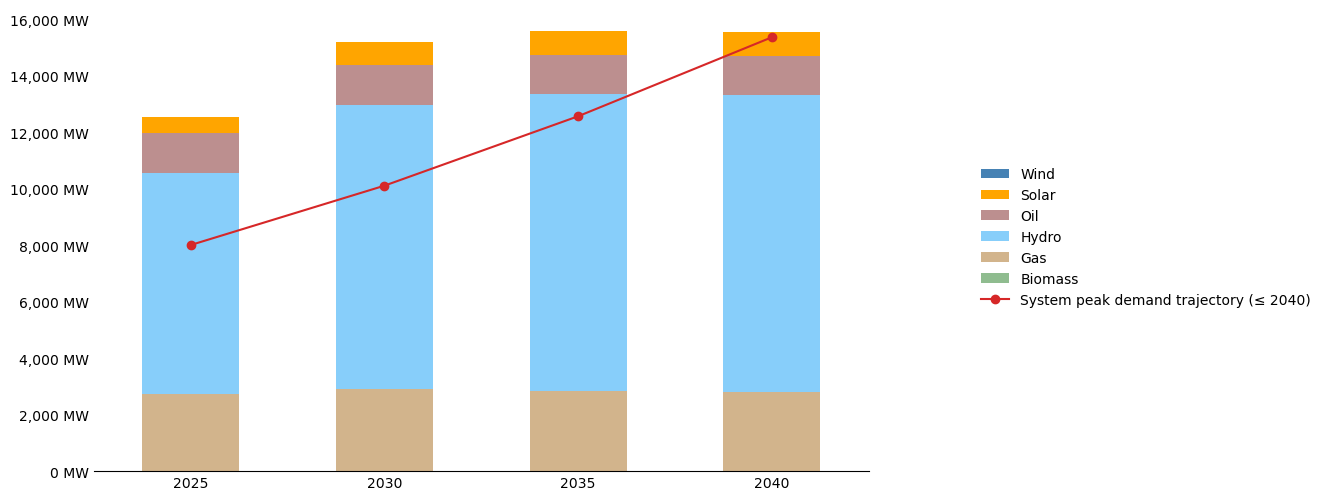

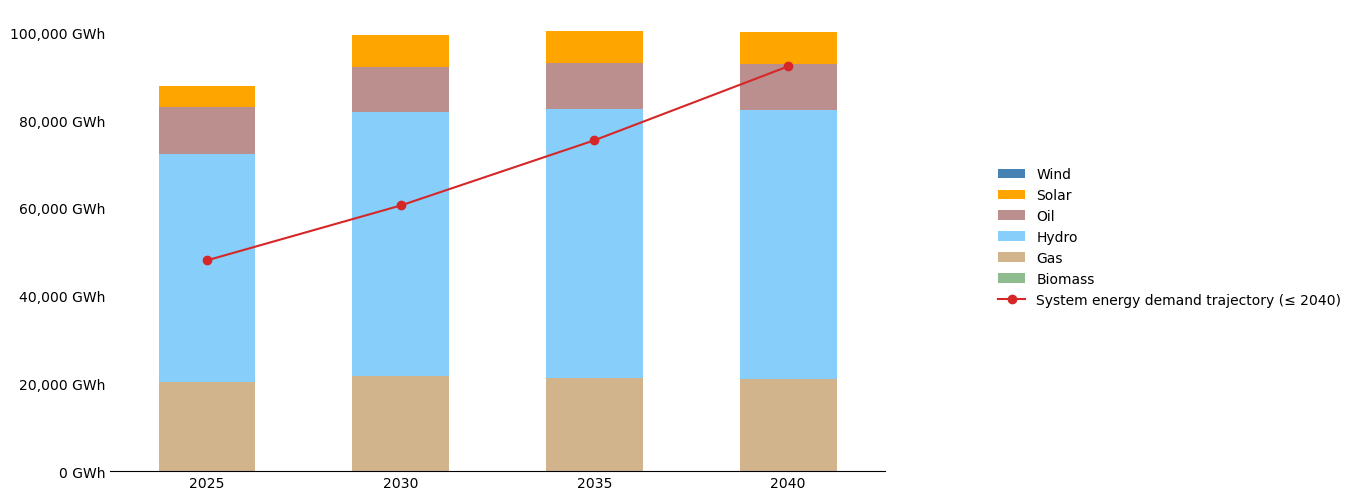

In [7]:
system_capacity_mix = (
    capacity_mix.groupby(['fuel', 'year'], observed=False)['value']
    .sum()
    .reset_index()
    .assign(zone='System')
)

system_energy_mix = (
    energy_mix.groupby(['fuel', 'year'], observed=False)['value']
    .sum()
    .reset_index()
    .assign(zone='System')
)

system_peak_demand = (
    peak_demand.groupby('year', observed=False)['value']
    .sum()
    .reset_index()
    .assign(zone='System')
)

system_energy_demand = (
    energy_demand.groupby('year', observed=False)['value']
    .sum()
    .reset_index()
    .assign(zone='System')
)

make_stacked_barplot(
    system_capacity_mix,
    filename=None,
    dict_colors=color_lookup,
    overlay_df=system_peak_demand,
    legend_label=f"System peak demand trajectory (≤ {TARGET_YEAR})",
    column_subplot='zone',
    column_stacked='fuel',
    column_xaxis='year',
    column_value='value',
    order_scenarios=model_years,
    annotate=False,
    format_y=lambda value, _: f"{value:,.0f} MW"
)

make_stacked_barplot(
    system_energy_mix,
    filename=None,
    dict_colors=color_lookup,
    overlay_df=system_energy_demand,
    legend_label=f"System energy demand trajectory (≤ {TARGET_YEAR})",
    column_subplot='zone',
    column_stacked='fuel',
    column_xaxis='year',
    column_value='value',
    order_scenarios=model_years,
    annotate=False,
    format_y=lambda value, _: f"{value:,.0f} GWh"
)

### Notes
- Update `folder_input` above if you want to explore a different dataset.
- Tweak `TARGET_YEAR` in Step 3 if you need a longer or shorter planning horizon.
- Re-run the cells sequentially after any data changes to refresh the plots.